In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 今後の処理を簡潔にするためfull_dataを作成

In [3]:
full_data = [train, test]

## ①欠損値の確認と処理

In [4]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


### 型確認

In [5]:
print(type(train['Cabin'][0]))
print(type(train['Cabin'][1]))

<class 'float'>
<class 'str'>


### Cabinの欠損値を0、欠損値でなければ1として新しい変数に代入

In [6]:
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1) # NaNはfloat型。それ以外はstr型。
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [7]:
train.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Has_Cabin
Embarked,,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69,168
Q,77,77,77,77,77,28,77,77,77,77,4,77
S,644,644,644,644,644,554,644,644,644,644,129,644


### 'Embarked'の欠損値を一番多い'S'で補完。

In [8]:
train['Embarked'] = train['Embarked'].fillna('S')

In [9]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.217703
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.413179
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,0.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000


### Fareの欠損値を中央値で補完

In [10]:
test['Fare'] = test['Fare'].fillna((train['Fare'].median()+test['Fare'].median())/2)

### Ageの欠損値を補完

In [11]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age']=dataset['Age'].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## ②説明変数同士の関係を図を用いて確認してみる

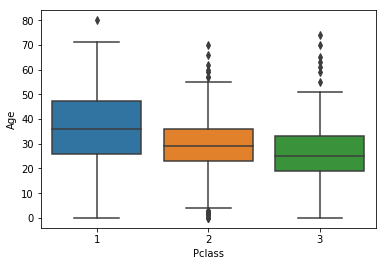

In [12]:
sns.boxplot(data=train, x='Pclass', y='Age')
plt.show()

- Pclassがいい人は年齢高い傾向にあることが分かる。(1 = 1st, 2 = 2nd, 3 = 3rd)

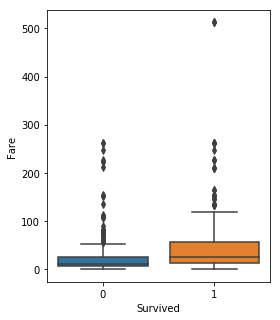

In [13]:
plt.figure(figsize=(4, 5))
sns.boxplot(data=train, x='Survived', y='Fare')
plt.show()

- 運賃が高い人は生き残っている人が多い傾向にある。

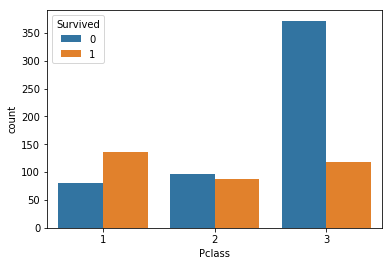

In [14]:
# チケットのランク毎の生存/死亡者数を棒グラフで可視化
sns.countplot(x='Pclass', hue='Survived', data=train) 
plt.show()

- チケットのランクが高い人が生き残った確率高い

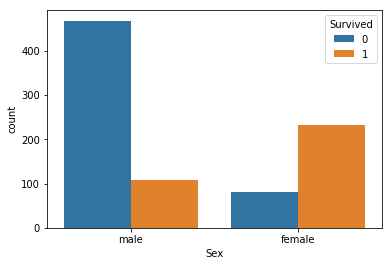

In [15]:
sns.countplot(x='Sex', hue='Survived', data=train)
plt.show()

- 女性の方が生き残った確率が高い

## ③説明変数を追加

### 「Name_length・・名前の長さ」の列を追加

In [16]:
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

### 「FamilySize・・家族の人数」の列を追加（SibSp・・兄弟、配偶者の数　Parch・・両親、子どもの数）　　

In [17]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

### 「IsAlone・・タイタニック号に一人で乗っているかどうか」の列を追加（一人のとき1、身内と一緒のとき0）

In [18]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

### Mr. Mrsなどの敬称について調べる

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Name_length,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,23,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,51,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,0,22,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,44,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,24,1,1


In [20]:
print(train['Name'][0].split(', '))

['Braund', 'Mr. Owen Harris']


In [21]:
print(train['Name'][0].split(', ')[1].split('.')[0])

Mr


### 「honorific(敬称)」の列を追加

In [22]:
for dataset in full_data:
    dataset['honorific'] = dataset['Name'].map(lambda x: x.split(', ')[1].split('.')[0])

### 「honorific(敬称)」の列を調整していく

In [23]:
train['honorific'].value_counts().to_frame()

,honorific
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
Ms,1


In [24]:
test['honorific'].value_counts().to_frame()

,honorific
Mr,240
Miss,78
Mrs,72
Master,21
Rev,2
Col,2
Dr,1
Dona,1
Ms,1


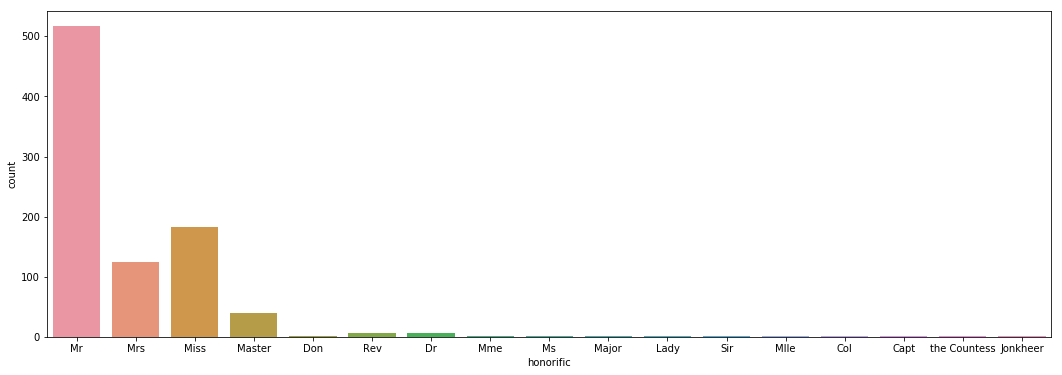

In [25]:
# 可視化
plt.figure(figsize=(18,6))
sns.countplot(x='honorific', data=train)
plt.show()

### 'Mlle'と'Ms' を'Miss'で置換し、あまり使われない敬称を'Rare'で置換

In [26]:
for dataset in full_data:
    dataset['honorific'].replace('Mlle', 'Miss', inplace=True) #Missに統合
    dataset['honorific'].replace('Ms', 'Miss', inplace=True) #Missに統合
    dataset['honorific'].replace(['Don','Rev','Dr','Mme','Major','Lady','Sir','Col','Capt','the Countess','Jonkheer','Dona'],'Rare', 
                                 inplace=True)

## ④不要な説明変数を削除しデータを整える

### 不要な説明変数を削除

In [27]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
train = train.drop(drop_elements, axis=1)
test = test.drop(drop_elements, axis=1)

### ダミー変数化

In [28]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

## ⑤モデル作成
1. ロジスティック回帰
2. 決定木
3. ランダムフォレスト
4. XGBoost
5. LightGBM
6. Neural Network
7. keras
8. n-近傍法

In [29]:
from sklearn.model_selection import KFold

In [30]:
train_x = train.drop('Survived', axis=1)
train_y = train['Survived']
test_x = test

In [31]:
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

### 1. ロジスティク回帰

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
from sklearn.metrics import log_loss

In [34]:
lr = LogisticRegression()
lr.fit(tr_x, tr_y)
lr_va_pred = lr.predict_proba(va_x)[:,1]
print(f'logloss:{log_loss(va_y, lr_va_pred)}')

logloss:0.4141011902903688


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 2. 決定木

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
dt = DecisionTreeClassifier(max_depth=3, random_state=71)
dt.fit(tr_x, tr_y)
dt_va_pred = dt.predict_proba(va_x)[:,1]
print(f'logloss:{log_loss(va_y, dt_va_pred)}')

logloss:0.4389256768218324


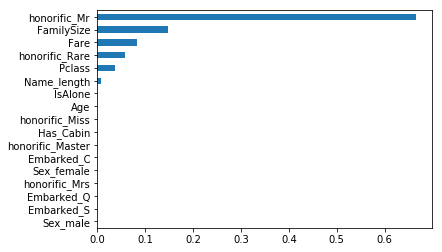

In [37]:
# 重要度の抽出
feature_importances = pd.Series(dt.feature_importances_, index=tr_x.columns).sort_values(ascending=True)
feature_importances[0:20].sort_values().plot.barh()
plt.show()

### 3. ランダムフォレスト

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
# グリッドサーチに必要なライブラリを読み込み
from sklearn.model_selection import GridSearchCV

In [40]:
# 探索するパラメータを設定
params = {
        'n_estimators' : [50, 100, 150],
        'max_depth' : [ 5, 10, 15,],
        'min_samples_split' : [2, 5, 10, 15],
        'min_samples_leaf' : [2, 4, 6],
        'random_state'      : [71]
}

# グリッドサーチの実行
grid = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid = params,
                    scoring='accuracy', n_jobs=-1, iid=False, cv=10
)
grid.fit(tr_x, tr_y)

# グリッドサーチ結果の表示
print(grid.best_params_, grid.best_score_)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 50, 'random_state': 71} 0.8367567243993934


In [41]:
rf = RandomForestClassifier(
  max_depth=10,
  min_samples_leaf=4,
  n_estimators=50,
  min_samples_split=15,
  n_jobs=-1,
  random_state=71)
rf.fit(tr_x, tr_y)
rf_va_pred = rf.predict_proba(va_x)
print(f'logloss:{log_loss(va_y, rf_va_pred)}')

logloss:0.3990805342702306


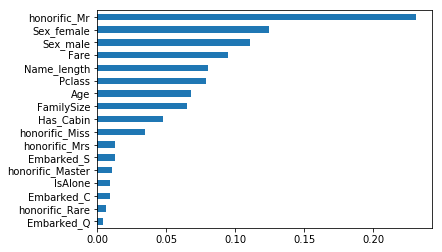

In [42]:
feature_importances = pd.Series(rf.feature_importances_, index=tr_x.columns).sort_values(ascending=True)
feature_importances[0:20].sort_values().plot.barh()
plt.show()

### 4. XGBoost

In [43]:
from xgboost.sklearn import XGBClassifier

In [44]:
param_space = {
    'n_estimator':[15,20,25],
    'max_depth':[3, 5, 7, 9],
    'min_child_weight':[2,4,8,16],
}

In [45]:
import itertools

In [46]:
param_combinations = itertools.product(param_space['n_estimator'], param_space['max_depth'], param_space['min_child_weight'])
params = []
scores = []

for n_estimator, max_depth, min_child_weight in param_combinations:
    score_folds = []
    xgb = XGBClassifier(n_estimator=n_estimator, random_state=71, max_depth=max_depth, min_child_weight=min_child_weight) 
    xgb.fit(tr_x, tr_y)
    xgb_va_pred = xgb.predict_proba(va_x)[:, 1]
    logloss = log_loss(va_y, xgb_va_pred)
    
    params.append((n_estimator, max_depth, min_child_weight))
    scores.append(logloss)
    
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'n_estimator:{best_param[0]},max_depth:{best_param[1]}, min_child_weight:{best_param[2]}, best_logloss{np.sort(scores)[0]}')

n_estimator:20,max_depth:5, min_child_weight:8, best_logloss0.3720619293773388


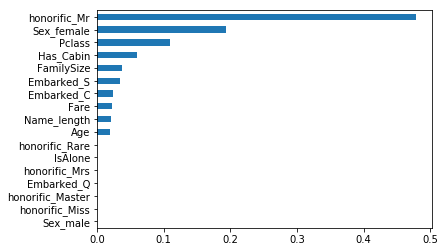

In [47]:
feature_importances = pd.Series(xgb.feature_importances_, index=tr_x.columns).sort_values(ascending=True)
feature_importances[0:20].sort_values().plot.barh()
plt.show()

### 5. lightGBM

In [48]:
import lightgbm as lgb

In [49]:
param_space = {
    'n_estimator':[15,20,25],
    'max_depth':[3, 5, 7, 9],
    'min_child_weight':[2,4,8,16],
}

In [50]:
param_combinations = itertools.product(param_space['n_estimator'], param_space['max_depth'], param_space['min_child_weight'])
params = []
scores = []

for n_estimator, max_depth, min_child_weight in param_combinations:
    score_folds = []
    gbm = lgb.LGBMClassifier(n_estimator=n_estimator, random_state=71, max_depth=max_depth, min_child_weight=min_child_weight) 
    gbm.fit(tr_x, tr_y)
    gbm_va_pred = gbm.predict_proba(va_x)[:, 1]
    logloss = log_loss(va_y, gbm_va_pred)
    
    params.append((n_estimator, max_depth, min_child_weight))
    scores.append(logloss)
    
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'n_estimator:{best_param[0]},max_depth:{best_param[1]}, min_child_weight:{best_param[2]}, best_logloss{np.sort(scores)[0]}')

n_estimator:25,max_depth:7, min_child_weight:8, best_logloss0.3752795754722003


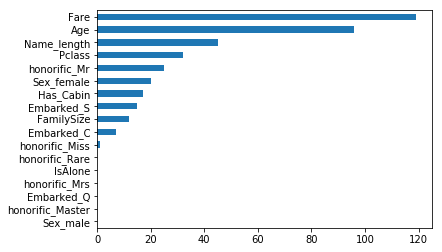

In [51]:
feature_importances = pd.Series(gbm.feature_importances_, index=tr_x.columns)
feature_importances[0:20].sort_values().plot.barh()
plt.show()

### 6.Neural Network

In [52]:
from sklearn.neural_network import MLPClassifier

In [53]:
NN = MLPClassifier(random_state=71)
NN.fit(tr_x, tr_y)
NN_va_pred = NN.predict_proba(va_x)[:,1]
print(f'logloss:{log_loss(va_y, NN_va_pred)}')

logloss:0.4292004288001338


### 7.keras

In [54]:
from keras.layers import Dense,Dropout
from keras.models import Sequential
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [55]:
Scaler = StandardScaler()
Scaler.fit(tr_x)
tr_x2 = Scaler.transform(tr_x)
va_x2 = Scaler.transform(va_x)
test_x2 = Scaler.transform(test_x)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(train_x.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0,2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  """




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [56]:
batch_size = 128
epochs = 10
history = model.fit(tr_x2, tr_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(va_x2, va_y))
keras_va_pred = model.predict(va_x2)
keras_test_pred = model.predict(test_x)
score = log_loss(va_y, keras_va_pred)
print(f'logloss:{score:.4f}')

Train on 668 samples, validate on 223 samples
Epoch 1/10
668/668 [==============================] - 2s 3ms/step - loss: 0.5988 - acc: 0.7036 - val_loss: 0.4657 - val_acc: 0.7982
Epoch 2/10
668/668 [==============================] - 0s 53us/step - loss: 0.4639 - acc: 0.8024 - val_loss: 0.4259 - val_acc: 0.8161
Epoch 3/10
668/668 [==============================] - 0s 56us/step - loss: 0.4231 - acc: 0.8159 - val_loss: 0.4315 - val_acc: 0.8296
Epoch 4/10
668/668 [==============================] - 0s 66us/step - loss: 0.4205 - acc: 0.8174 - val_loss: 0.4262 - val_acc: 0.8341
Epoch 5/10
668/668 [==============================] - 0s 61us/step - loss: 0.3997 - acc: 0.8368 - val_loss: 0.4174 - val_acc: 0.8386
Epoch 6/10
668/668 [==============================] - 0s 81us/step - loss: 0.3944 - acc: 0.8443 - val_loss: 0.4179 - val_acc: 0.8296
Epoch 7/10
668/668 [==============================] - 0s 59us/step - loss: 0.3913 - acc: 0.8383 - val_loss: 0.4242 - val_acc: 0.8430
Epoch 8/10
668/668 [====

### 8. k-nn近傍法

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(tr_x, tr_y)
knn_va_pred = knn.predict_proba(va_x)
print(f'logloss{log_loss(va_y, knn_va_pred)}')

logloss0.5082894235256578


## ⑥アンサンブル学習

In [59]:
lr_test_pred = lr.predict_proba(test_x)[:,1]
rf_test_pred = rf.predict_proba(test_x)[:,1]
xgb_test_pred = xgb.predict_proba(test_x)[:,1]
gbm_test_pred = gbm.predict_proba(test_x)[:,1]
NN_test_pred = knn.predict_proba(test_x)[:,1]

In [60]:
test_pred = lr_test_pred*0.1 + rf_test_pred*0.6 + xgb_test_pred*0.1 + gbm_test_pred*0.1 + NN_test_pred*0.1

In [61]:
test_y = np.where(test_pred>0.5, 1, 0)

In [78]:
submission = pd.DataFrame({'PassengerId': PassengerId, 
                           'Survived': test_y})

In [79]:
submission.to_csv('submission.csv', index=False)